## Model Refinement


### 1. Diagnose model issues


* Here is the code implementing Model Refinement using the following steps:-

* Model issue diagnosis (e.g., high bias, variance)

* Error analysis

* Feature improvement

* Model experimentation (XGBoost and RandomForest as examples)

* Hyperparameter tuning (via GridSearchCV)

### a. Load Dataset and Preprocessing


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt

# Load and sort data
df = pd.read_csv(r"D:\Menternship Project\final_merged_dataset_cleaned.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")

# Select features
features = [
    'hour', 'day_of_week', 'month', 'lag_1h', 'lag_24h', 'lag_168h',
    'is_weekend', 'temp', 'humidity', 'precipitation', 'windspeed',
    'concert', 'holiday', 'sports_event', 'protest',
    'pickup_location', 'dropoff_location', 'trip_status',
    'weather_condition', 'traffic_level'
]
target = 'vehicle_count'

X = df[features].copy()
y = df[target]

# Encode categorical features
categorical_cols = X.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


### b. Time Series Cross-Validation & Model Evaluation


In [11]:
tscv = TimeSeriesSplit(n_splits=5)
mae_scores, rmse_scores, r2_scores = [], [], []
residuals_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, preds))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    r2_scores.append(r2_score(y_test, preds))

    residuals_list.append(y_test - preds)
    print(f"Fold {fold+1} - MAE: {mae_scores[-1]:.4f}, RMSE: {rmse_scores[-1]:.4f}, R²: {r2_scores[-1]:.4f}")

print("\nCross-Validation Summary:")
print(f"Avg MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Avg R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1 - MAE: 0.0157, RMSE: 0.0242, R²: 0.8936
Fold 2 - MAE: 0.0148, RMSE: 0.0249, R²: 0.9242
Fold 3 - MAE: 0.0161, RMSE: 0.0270, R²: 0.9374
Fold 4 - MAE: 0.0159, RMSE: 0.0266, R²: 0.9580
Fold 5 - MAE: 0.0151, RMSE: 0.0283, R²: 0.9575

Cross-Validation Summary:
Avg MAE: 0.0155 ± 0.0005
Avg RMSE: 0.0262 ± 0.0015
Avg R²: 0.9341 ± 0.0240


### c. Error Analysis (Visualize Residuals)


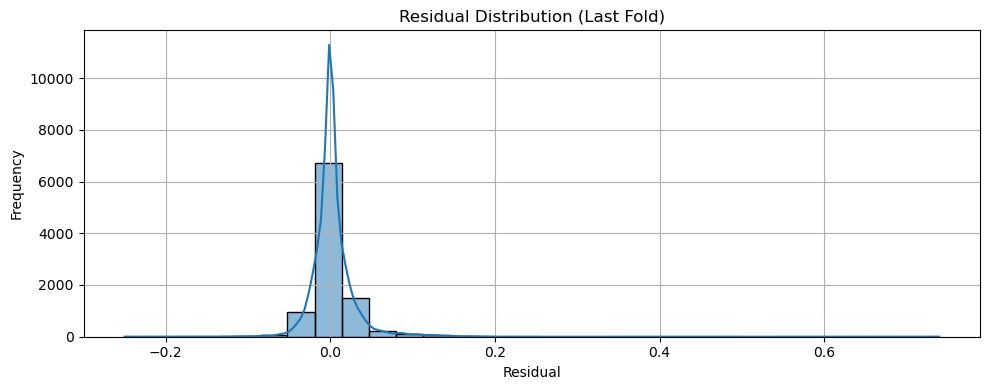

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot residuals from the last fold
residuals = residuals_list[-1]
plt.figure(figsize=(10, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residual Distribution (Last Fold)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


### 4. Diagnose Issues


In [18]:
print("\n🔍 Model Diagnosis:")
if np.mean(r2_scores) < 0.1:
    print("⚠️ Low R² → underfitting (try adding features or a more complex model)")
if r2_scores[0] - r2_scores[-1] > 0.2:
    print("⚠️ R² dropped over time → potential concept drift or overfitting")
if np.std(mae_scores) > 0.05 * np.mean(mae_scores):
    print("⚠️ High MAE variance across folds → high variance (overfitting risk)")
else:
    print("✅ No major signs of overfitting or underfitting detected.")



🔍 Model Diagnosis:
✅ No major signs of overfitting or underfitting detected.


### 5. Try Alternative Model: Random Forest


In [21]:
print("\n🌲 Trying Random Forest...")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f"Random Forest → MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")



🌲 Trying Random Forest...
Random Forest → MAE: 0.0144, RMSE: 0.0261, R²: 0.9637


### 6. Hyperparameter Tuning via GridSearchCV


In [24]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_absolute_error',
    verbose=1
)
grid_search.fit(X, y)

print("\n Grid Search Results:")
print("Best Parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits

 Grid Search Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best MAE: 0.014279160802354364
